<a href="https://colab.research.google.com/github/ejnunn/GAN_Research/blob/main/notebooks/CycleGAN_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Utils

In [ ]:
!rm -r GAN_Research
!git clone https://github.com/ejnunn/GAN_Research.git

rm: cannot remove 'GAN_Research': No such file or directory
Cloning into 'GAN_Research'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 206 (delta 118), reused 92 (delta 39), pack-reused 0
Receiving objects: 100% (206/206), 6.77 MiB | 12.57 MiB/s, done.
Resolving deltas: 100% (118/118), done.


## Library Imports

In [50]:
import torch
from torch import nn
from tqdm.auto import tqdm # progress bars
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt # visualizations
import pandas as pd # data processing
import shutil # file management
import torch.nn.functional as F # used in Hyperparameters cell
from skimage import color
import numpy as np

from GAN_Research.GAN_Research.GAN_Research.utils import *
from GAN_Research.models.cycleGAN_losses import *
from GAN_Research.scripts.datasets import ImageDataset
from GAN_Research.models.CycleGAN import CycleGAN


DRIVE_DATASETS = '/content/drive/MyDrive/GAN_Research/Datasets/'

torch.manual_seed(0)

# Load data

## Load CelebA Dataset

In [ ]:
## Create two groups of image files, smiling and not smiling ##

# Create dataframe to sort CelebA images
img_dir_celeba = '/content/drive/MyDrive/GAN Research/CycleGAN/CycleGAN Images/CelebA/'
attr_filename = 'list_attr_celeba.txt'

df = pd.read_csv(img_dir_celeba + attr_filename, skiprows=1, delim_whitespace=True)
df = df.reset_index()
df.rename(columns={'index': 'filename'}, inplace=True)

# Lists of smiling and non-smiling image filenames
smiling_list = list(df[['filename']].loc[df['Smiling'] == 1]['filename'])
not_smiling_list = list(df[['filename']].loc[df['Smiling'] == -1]['filename'])

In [ ]:
## Unzip images and move files into the correct category ##

# Unzip images from drive and store in current directory
!unzip -q /content/drive/MyDrive/GAN\ Research/CycleGAN/CycleGAN\ Images/CelebA/img_align_celeba.zip

# Create training A and B subdirectories
!mkdir img_align_celeba/trainA
!mkdir img_align_celeba/trainB

# Move images into correct subdirectory
source_dir = 'img_align_celeba/'
destination_dir = 'img_align_celeba/trainA'
for img in smiling_list:
  shutil.move(source_dir + img, destination_dir)

source_dir = 'img_align_celeba/'
destination_dir = 'img_align_celeba/trainB'
for img in not_smiling_list:
  shutil.move(source_dir + img, destination_dir)
print('images loaded successfully!')

images loaded successfully!


In [39]:
## Load files into a Image Dataset object ##
load_shape = 128
target_shape = 128
# Apply transforms to dataset to augment
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

img_dir = 'img_align_celeba'
training_max_images = 2000
dataset = ImageDataset(img_dir, transform=transform, max_size=training_max_images)

print("Size of dataset: {} images".format(len(dataset)))

Size of dataset: 2000 images


# Training

In [ ]:
# pretrained cycleGAN weights
weights_file = '/content/drive/MyDrive/GAN Research/CycleGAN/models/smile/smile_80_25_30_15.pth'
cyclegan = CycleGAN(weights_file=weights_file)

Epoch 0: Step 0: Generator (U-Net) loss: 0.0043881387710571285, Discriminator loss: 0.0012236934900283812


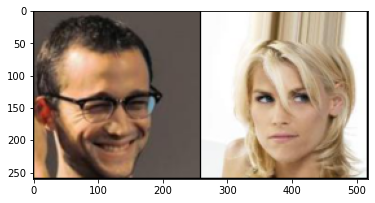

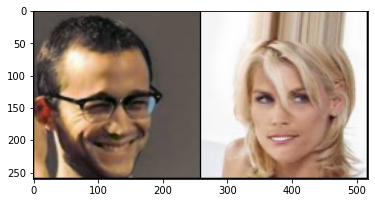

In [ ]:
cyclegan.train(dataset)

# Save Images

In [57]:
from torchvision.utils import save_image

# Save 2k generated images from GAN
i = 0
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_dir = 'CelebA_Smiles/'
dir_real_A = DRIVE_DATASETS + dataset_dir + 'real_A/'
dir_fake_A = DRIVE_DATASETS + dataset_dir + 'fake_A/'
dir_real_B = DRIVE_DATASETS + dataset_dir + 'real_B/'
dir_fake_B = DRIVE_DATASETS + dataset_dir + 'fake_B/'

for real_A, real_B in tqdm(dataloader):
  real_A = real_A.to(device)
  real_B = real_B.to(device)
  fake_A = cyclegan.gen_BA(real_B)
  fake_B = cyclegan.gen_AB(real_A)

  # if i % 100 == 0:
  #   print(i)
  #   show_tensor_images(torch.cat([fake_A, fake_B]), size=(cyclegan.dim_A, target_shape, target_shape))
  
  # detach from GPU
  real_A = real_A.cpu()
  real_B = real_B.cpu()
  fake_A = fake_A.cpu()
  fake_B = fake_B.cpu()

  # Normalize to (-1,1) instead of (0,1)
  real_A = real_A.sub_(0.5).div_(0.5)
  real_B = real_B.sub_(0.5).div_(0.5)
  fake_A = fake_A.sub_(0.5).div_(0.5)
  fake_B = fake_B.sub_(0.5).div_(0.5)

  # Save images
  save_image(real_A, '{}{}.jpg'.format(dir_real_A, str(i)))
  save_image(fake_A, '{}{}.jpg'.format(dir_fake_A, str(i)))
  save_image(real_B, '{}{}.jpg'.format(dir_real_B, str(i)))
  save_image(fake_B, '{}{}.jpg'.format(dir_fake_B, str(i)))

  i += 1